In [1]:
import pandas as pd
import gc
import sys
import os
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
src_path = os.path.abspath(r'C:\Users\User\OneDrive - Imperial College London\Desktop\Documents\GitHub\Credit-Card\src')
sys.path.append(src_path)

from adtk.data import validate_series
from adtk.detector import QuantileAD, ThresholdAD
from adtk.visualization import plot

from feature_engineering.encoding import group_low_frequency_categories, encode_categories, log_encode
from feature_engineering.new_features import calculate_time_delta, extract_bin, extract_check_digit, extract_datetime_component, average_transactions_per_time, transactions_in_last_interval,transactions_last_minute
from data.db_functions import query_data
from data.clean_data import update_dtypes

gc.collect()

4

In [2]:
db_dir = r'C:\Users\User\OneDrive - Imperial College London\Desktop\Documents\GitHub\Credit-Card\data\database (SQLite)\raw_data.db'

query = "SELECT * FROM raw_data WHERE business_id IN ('640fdf71d95a90ebc209167d')"

with sqlite3.connect(db_dir) as conn:
    df = pd.read_sql_query(query, conn)


df.head()
df.shape
df.dtypes

business_id                         object
auth_status                         object
eci                                 object
descriptor                          object
auth_failure_reason                 object
charge_failure_reason               object
amount                             float64
authorized_amount                  float64
mid_label                           object
bank_merchant_id                    object
capture_amount                     float64
created                             object
authentication_type                 object
card_bank                           object
card_brand                          object
card_expiration_month                int64
card_expiration_year                 int64
cavv                                object
country                             object
currency                            object
ip_address                          object
masked_card_number                  object
card_holder_name                    object
card_type  

In [3]:
df = update_dtypes(df)
df.dtypes

df = df.dropna(subset=['created'])

nan_counts = df.isna().sum()
print("NaN values in each column:")
print(nan_counts[nan_counts > 0])

C:\Users\User\OneDrive - Imperial College London\Desktop\Documents\GitHub\Credit-Card\src\data\clean_data.py:76: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column] = df[column].replace({1: True, 0: False, 'true': True, 'false': False, 'True': True, 'False': False}).astype('boolean')


Total rows: 1463123
Number of rows dropped: 0
NaN values in each column:
auth_failure_reason      1461430
charge_failure_reason     446239
ip_address               1461739
card_holder_name         1461739
dtype: int64


In [4]:
df['card_bin'] = extract_bin(df, 'masked_card_number')
df['check_digit'] = extract_check_digit(df, 'masked_card_number')
df['business_delta'] = calculate_time_delta(df, 'created', 'business_id')
df['bin_delta'] = calculate_time_delta(df, 'created', 'card_bin')
df['month'] = extract_datetime_component(df, 'created', 'month')
df['day'] = extract_datetime_component(df, 'created', 'day')
df['hour'] = extract_datetime_component(df, 'created', 'hour')
df['minute'] = extract_datetime_component(df, 'created', 'minute')
df['time'] = extract_datetime_component(df, 'created', 'time')
df['mean_transactions_time'] = average_transactions_per_time(df, 'time')



nan_counts = df.isna().sum()
print("NaN values in each column:")
print(nan_counts[nan_counts > 0])
df.columns

C:\Users\User\OneDrive - Imperial College London\Desktop\Documents\GitHub\Credit-Card\src\feature_engineering\new_features.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time_delta = df.groupby(ref_col)[time_col].diff().dt.total_seconds()


NaN values in each column:
auth_failure_reason      1461430
charge_failure_reason     446239
ip_address               1461739
card_holder_name         1461739
business_delta                 1
bin_delta                  10395
dtype: int64


Index(['business_id', 'auth_status', 'eci', 'descriptor',
       'auth_failure_reason', 'charge_failure_reason', 'amount',
       'authorized_amount', 'mid_label', 'bank_merchant_id', 'capture_amount',
       'created', 'authentication_type', 'card_bank', 'card_brand',
       'card_expiration_month', 'card_expiration_year', 'cavv', 'country',
       'currency', 'ip_address', 'masked_card_number', 'card_holder_name',
       'card_type', 'is_blocked_by_fraud', 'is_cvn_submitted',
       'should_authenticate_credit_card', 'should_settle_directly', 'card_bin',
       'check_digit', 'business_delta', 'bin_delta', 'month', 'day', 'hour',
       'minute', 'time', 'mean_transactions_time'],
      dtype='object')

In [5]:
df = df[(df['created'] >= '2023-12-01') & (df['created'] < '2024-03-01')]
print(df.shape)
df = df.sort_values(by=['created', 'card_bin'], ascending=True)

df['last_1M_count'] = transactions_last_minute(df, 'created')



df_copy = df

(219925, 38)


Counting transactions in last minute: 100%|██████████| 219925/219925 [05:49<00:00, 628.50it/s]


In [6]:
pd.set_option('display.max_columns', None)
df.tail()

,business_id,auth_status,eci,descriptor,auth_failure_reason,charge_failure_reason,amount,authorized_amount,mid_label,bank_merchant_id,capture_amount,created,authentication_type,card_bank,card_brand,card_expiration_month,card_expiration_year,cavv,country,currency,ip_address,masked_card_number,card_holder_name,card_type,is_blocked_by_fraud,is_cvn_submitted,should_authenticate_credit_card,should_settle_directly,card_bin,check_digit,business_delta,bin_delta,month,day,hour,minute,time,mean_transactions_time,last_1M_count
524605,640fdf71d95a90ebc209167d,USED,5.0,"GLOBE TELECOM, INC.",NaN,NaN,62.000000,62.000000,MPGS_GLOBE_WEBLOADING_EC,073006686105,62.000000,2024-02-29 23:55:52.325,BUNDLED,UNION BANK OF THE PHILIPPINES,VISA,9,2027,AAICBUUwmQAAABg4YIBgdAAAAAA=,PHILIPPINES,PHP,NaN,41629501XXXX0731,NaN,DEBIT,False,1,True,True,416295,1,202.503,8343.774,2,29,23,55,23:55,1.081671,1
370842,640fdf71d95a90ebc209167d,USED,5.0,"GLOBE TELECOM, INC.",NaN,NaN,2072.310059,2072.310059,MPGS_GLOBE_INNOVE_BILLSPAY,073008753012,2072.310059,2024-02-29 23:56:16.281,BUNDLED,PHILIPPINE NATIONAL BANK,VISA,11,2025,AAIBCDWTcgAAAyl/YIBgdAAAAAA=,PHILIPPINES,PHP,NaN,48890890XXXX0596,NaN,CREDIT,False,1,True,True,488908,6,23.956,68663.975,2,29,23,56,23:56,1.010741,2
324283,640fdf71d95a90ebc209167d,USED,2.0,"GLOBE TELECOM, INC.",NaN,NaN,3859.000000,3859.000000,MPGS_GLOBE_BILLSPAY,073006686104,3859.000000,2024-02-29 23:58:05.871,BUNDLED,BANK OF THE PHILIPPINE ISLANDS,MASTERCARD,3,2026,kBMYHQwAnKivJVvQC59+g2CBS21z,PHILIPPINES,PHP,NaN,53634700XXXX4288,NaN,DEBIT,False,1,True,True,536347,8,109.590,2012.038,2,29,23,58,23:58,0.979217,1
177678,640fdf71d95a90ebc209167d,USED,5.0,"GLOBE TELECOM, INC.",NaN,NaN,20.000000,20.000000,MPGS_GLOBE_WEBLOADING_EC,073006686105,20.000000,2024-02-29 23:58:20.382,BUNDLED,UNION BANK OF THE PHILIPPINES,VISA,11,2030,AAICBGgoNAAAAAfQYIBgdAAAAAA=,THE UNITED STATES OF AMERICA,PHP,NaN,41629822XXXX0065,NaN,DEBIT,False,1,True,True,416298,5,14.511,85317.229,2,29,23,58,23:58,0.979217,2
84886,640fdf71d95a90ebc209167d,USED,2.0,"GLOBE TELECOM, INC.",NaN,NaN,3799.000000,3799.000000,MPGS_GLOBE_BILLSPAY,073006686104,3799.000000,2024-02-29 23:58:40.855,BUNDLED,BANK OF THE PHILIPPINE ISLANDS,MASTERCARD,11,2025,kBMYHAcAw7p+2lujC59+g2CBXxog,PHILIPPINES,PHP,NaN,54880937XXXX6586,NaN,CREDIT,False,1,True,True,548809,6,20.473,2363.974,2,29,23,58,23:58,0.979217,3


In [7]:
df_copy['created'] = pd.to_datetime(df_copy['created'])
df_copy.set_index('created', inplace=True)


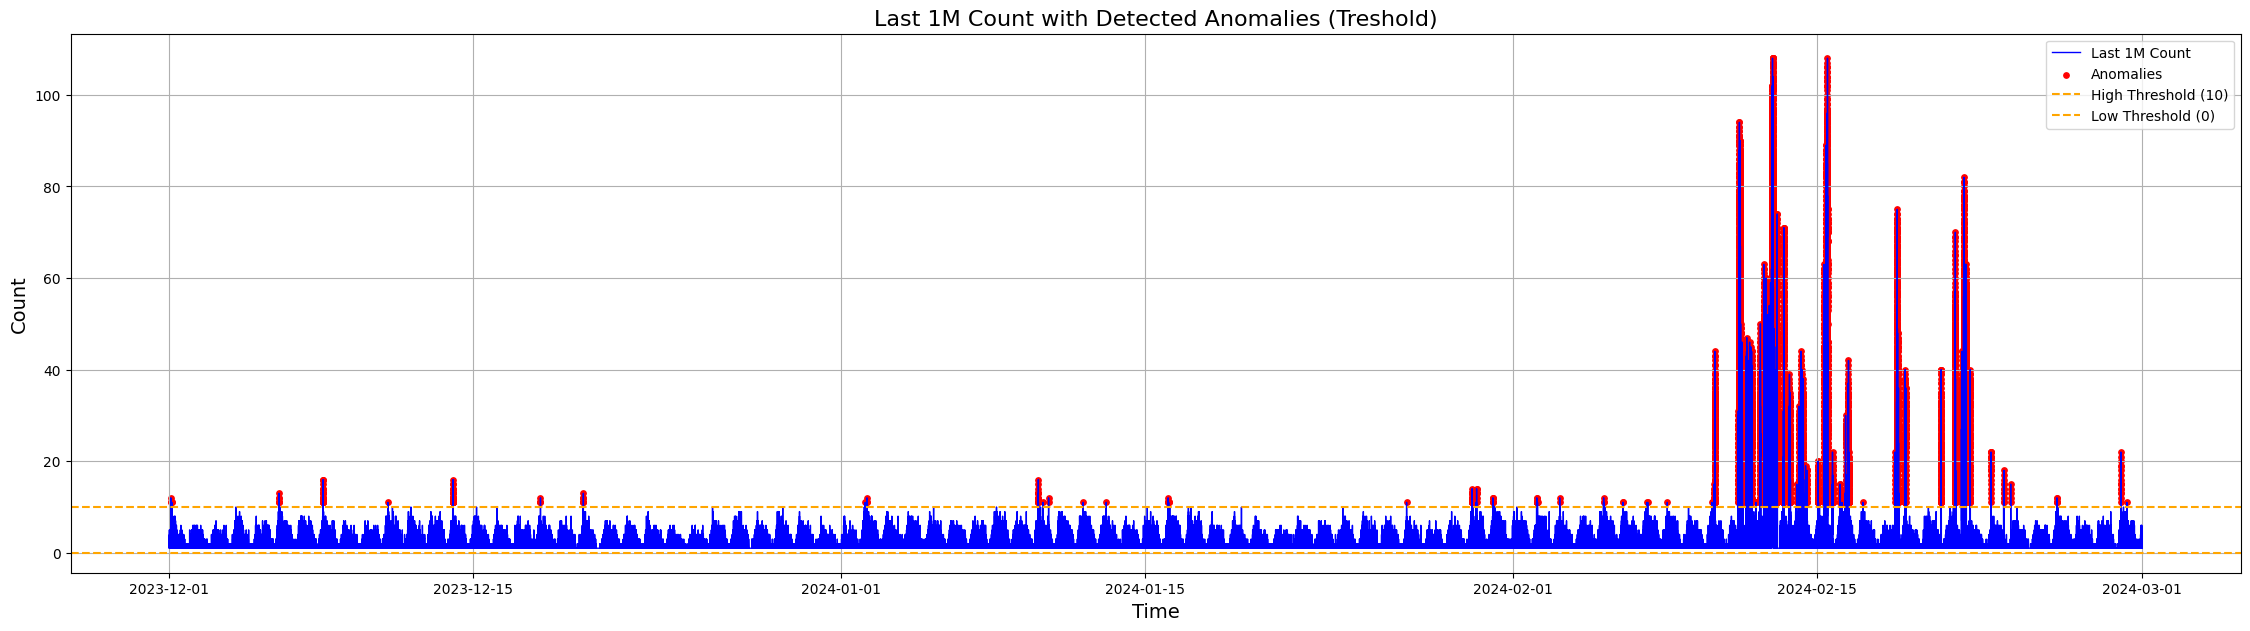

In [20]:


# Validate the last_1M_count series
last_1M_count_series = validate_series(df_copy['last_1M_count'])

# Set up ThresholdAD with desired thresholds
# Adjust these values based on your data context
threshold_ad = ThresholdAD(high=10, low=0)  # Example thresholds

# Detect anomalies
anomalies = threshold_ad.detect(last_1M_count_series)

# Add the anomalies to the DataFrame
df_copy['anomaly'] = anomalies

# Visualize the results using matplotlib
plt.figure(figsize=(28, 7))

# Plot the time series data
plt.plot(last_1M_count_series.index, last_1M_count_series.values, label='Last 1M Count', color='blue', linewidth=1)

# Plot the anomalies
anomaly_indices = last_1M_count_series.index[anomalies]  # Get the indices of the anomalies
plt.scatter(anomaly_indices, last_1M_count_series[anomalies], color='red', label='Anomalies', marker='o', s=15)

# Add titles and labels
plt.title('Last 1M Count with Detected Anomalies (Treshold)', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.axhline(y=10, color='orange', linestyle='--', label='High Threshold (10)')
plt.axhline(y=0, color='orange', linestyle='--', label='Low Threshold (0)')
plt.legend()
plt.grid()
plt.show()

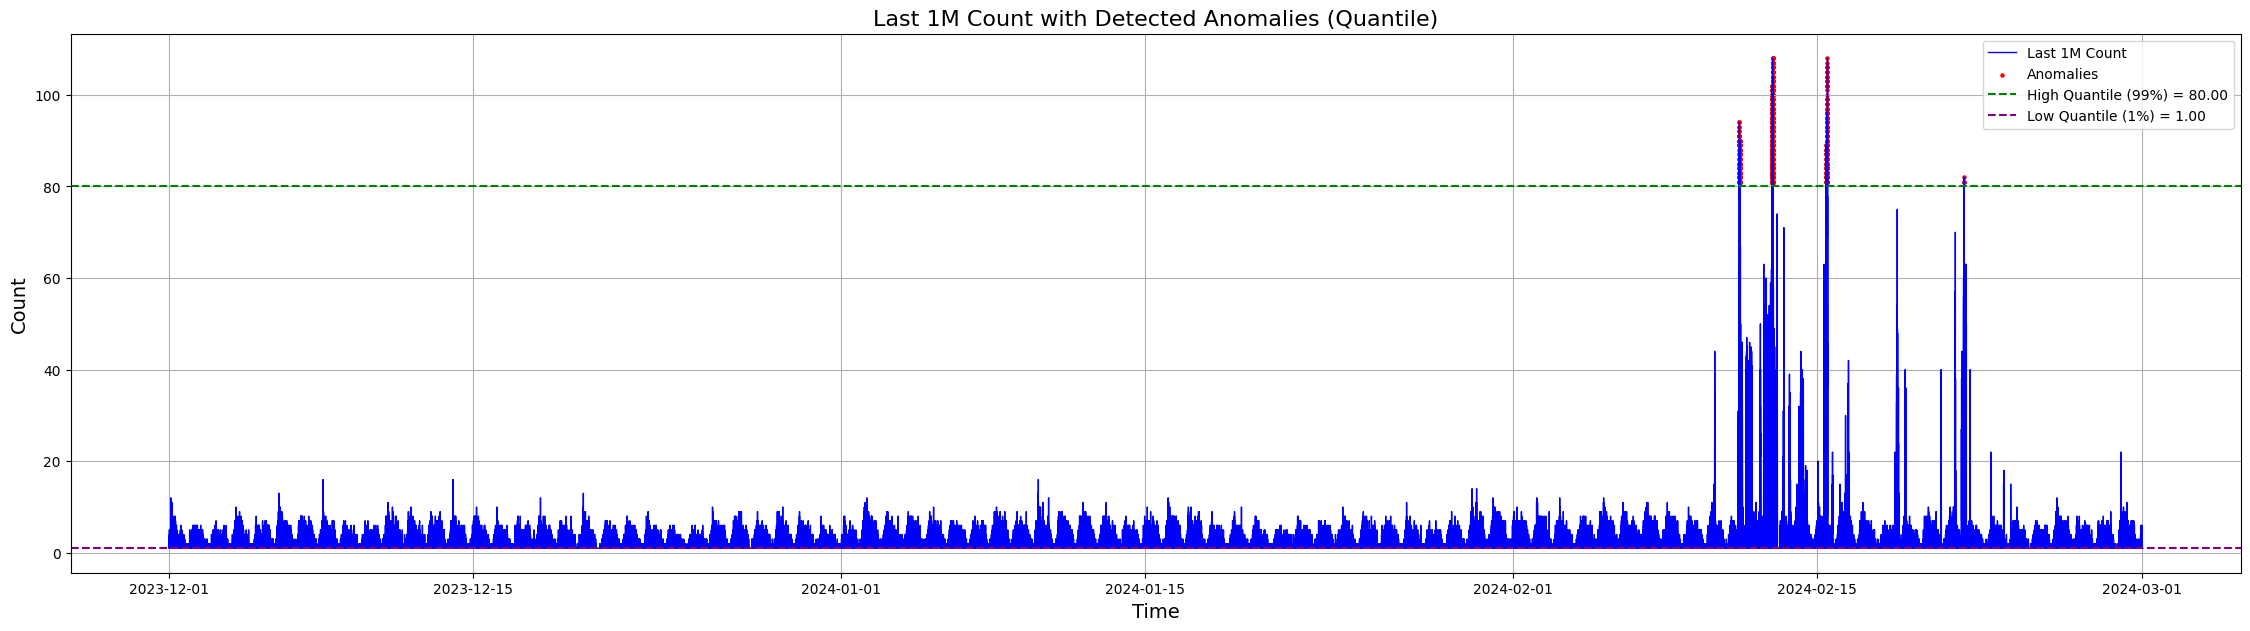

In [18]:
# Fit and detect anomalies using QuantileAD
threshold_ad = QuantileAD(low=0.01, high=0.99)  # Set low and high quantiles
anomalies = threshold_ad.fit_detect(last_1M_count_series)

# Add the anomalies to the DataFrame
df_copy['anomaly'] = anomalies

# Visualize the results using matplotlib
plt.figure(figsize=(28, 7))

# Plot the time series data
plt.plot(last_1M_count_series.index, last_1M_count_series.values, label='Last 1M Count', color='blue', linewidth=1)

# Plot the anomalies as red markers
anomaly_indices = last_1M_count_series.index[anomalies]  # Get the indices of the anomalies
plt.scatter(anomaly_indices, last_1M_count_series[anomalies], color='red', label='Anomalies', marker='o', s=5)

# Plot quantile lines based on the actual values in the series
low_quantile_value = last_1M_count_series.quantile(0.01)
high_quantile_value = last_1M_count_series.quantile(0.99)

# Plot horizontal lines for the quantile thresholds
plt.axhline(y=high_quantile_value, color='green', linestyle='--', label=f'High Quantile (99%) = {high_quantile_value:.2f}')
plt.axhline(y=low_quantile_value, color='purple', linestyle='--', label=f'Low Quantile (1%) = {low_quantile_value:.2f}')
plt.title('Last 1M Count with Detected Anomalies (Quantile)', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [9]:
gc.collect()


# time delta business
# time delta card
# time delta same card but diff merchant
# various time accelerations diff of diff
# sliding time window approach

7261